In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_gen = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    './dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 flower classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, epochs=15, callbacks=[early_stop])
model.save('flower_model.keras')

c:\Computer_Science\python\environments\machine_learning\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 45s 587ms/step - accuracy: 0.5654 - loss: 1.1251 - val_accuracy: 0.8321 - val_loss: 0.4669
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 681ms/step - accuracy: 0.8162 - loss: 0.4913 - val_accuracy: 0.8394 - val_loss: 0.4216
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 559ms/step - accuracy: 0.8590 - loss: 0.3770 - val_accuracy: 0.8467 - val_loss: 0.3856
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 559ms/step - accuracy: 0.8822 - loss: 0.3305 - val_accuracy: 0.8631 - val_loss: 0.3761
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 562ms/step - accuracy: 0.8981 - loss: 0.2991 - val_accuracy: 0.8668 - val_loss: 0.3776
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 562ms/step - accuracy: 0.8901 - loss: 0.2827 - val_accuracy: 0.8704 - val_loss: 0.3851
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 562ms/step - accuracy: 0.8993 - loss: 0.2615 - val_accuracy: 0.8668 - val_loss: 0.3499
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 557ms/step - accuracy: 0.9045 - loss: 0.2557 - val_accu

In [4]:
# evaluate the model
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.8601 - loss: 0.3664
Validation Loss: 0.3898, Validation Accuracy: 0.8631


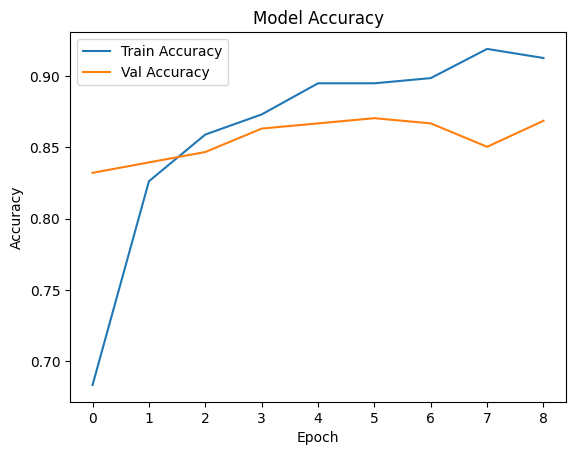

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt # If you want to plot confusion matrix later

# Reset the generator to ensure it starts from the beginning
val_gen.reset()

# Predict
# It's good practice to specify steps to ensure all data is processed
y_pred_proba = model.predict(val_gen, steps=len(val_gen), verbose=1)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Get true labels in the correct order
# val_gen.classes directly might not be ordered correctly with predictions
# A more robust way is to iterate and collect them:
y_true = []
for i in range(len(val_gen)): # len(val_gen) is the number of batches
    _, label_batch = val_gen[i] # Get images and labels for batch i
    y_true.extend(np.argmax(label_batch, axis=1)) # Assuming labels are one-hot
y_true = np.array(y_true)

# Ensure y_true has the same length as y_pred_classes
# This might be necessary if the last batch isn't full and steps isn't exact
# However, with steps=len(val_gen), it should align.
# If there's still a mismatch, you might need to cap y_true:
# y_true = y_true[:len(y_pred_classes)]


print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))
print("\nClassification Report:")
# It's helpful to add target_names if you know them
class_labels = list(val_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 435ms/step
Confusion Matrix:
[[14 22 17 13 34]
 [24 25 14 27 39]
 [24 21 15 19 20]
 [12 28 14 16 29]
 [26 32 18 13 32]]

Classification Report:
              precision    recall  f1-score   support

       daisy       0.14      0.14      0.14       100
   dandelion       0.20      0.19      0.19       129
        rose       0.19      0.15      0.17        99
   sunflower       0.18      0.16      0.17        99
       tulip       0.21      0.26      0.23       121

    accuracy                           0.19       548
   macro avg       0.18      0.18      0.18       548
weighted avg       0.18      0.19      0.18       548

